# A code to suggest cocktails based on ingredients

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import csv
import time
import re
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

### First, we get the recipes from www.drinksmixer.com . 

We get the receipes links first.

In [72]:
page_address = []
for i in range(1,9):
    page_address.append("http://www.drinksmixer.com/search/?q=cocktail&d=1&p=" + str(i))

list_1 = []

for i in range(8):   
    page = requests.get(page_address[i], time.sleep(.2))
    
    
#create beautiful soup object
    soup = bs(page.text, 'html.parser')


    for i in range(2):
        list_1.append(soup.find_all(class_= "l1a")[i].find_all("a"))

###flatten list_1
list_flat = [item for sublist in list_1 for item in sublist]


link_tails = []
for i in range(len(list_flat)):
        link_tails.append(list_flat[i]["href"])
        
        
### Now Build the recipe links ###

recipe_links = []
for i in range(len(link_tails)):
    recipe_links.append("http://www.drinksmixer.com" + link_tails[i]) 
    


In [73]:
recipe_links[0:10]

['http://www.drinksmixer.com/drink10391.html',
 'http://www.drinksmixer.com/drink7469.html',
 'http://www.drinksmixer.com/drink10313.html',
 'http://www.drinksmixer.com/drink8489.html',
 'http://www.drinksmixer.com/drink688.html',
 'http://www.drinksmixer.com/drink694.html',
 'http://www.drinksmixer.com/drink3411.html',
 'http://www.drinksmixer.com/drink740.html',
 'http://www.drinksmixer.com/drink746.html',
 'http://www.drinksmixer.com/drink750.html']

Now we get the recipes:

In [341]:
cocktail_rec = []
for link in recipe_links:
    
    page = requests.get(link, time.sleep(.5))

    soup = bs(page.text, 'html.parser')

    cocktail_name = soup.find(class_ = "fn recipe_title").string


    ing_name = soup.find(class_ = "ingredients").find_all(class_="name")
    ing_amount = soup.find(class_ = "ingredients").find_all(class_="amount")

    rating = soup.find(class_ = "ratingsBox rating").find("div",{"style":"font-size:36px; font-weight: bold;"})
    votes_num = soup.find(class_ = "ratingsBox rating").find("span",{"class":"count"})
    
    if rating != None:
        rating = rating.string
    if votes_num != None:
        votes_num = votes_num.string

    ingredients = [item.string for item in ing_name]

    cocktail_el = [cocktail_name, ingredients, rating, votes_num]
    cocktail_rec.append(cocktail_el)

cocktail_rec is now a nested list: [cocktail_name, [ingredients], rating, votes_num]

In [3]:
# total of 712 rec
# len(cocktail_rec)

In [342]:
###  connect the words in ingredients,,, we don't want to match "juice"
###  with "juice", orange juice --> orangejuice, lime juice -->limejuice
    
for j in range(len(cocktail_rec)):
    for i in range(len(cocktail_rec[j][1])):
        cocktail_rec[j][1][i] = cocktail_rec[j][1][i].replace(" ","")

In [343]:
for i in range(len(cocktail_rec)):
    rec=""
    for word in cocktail_rec[i][1]:
        rec = rec + word + " "
    cocktail_rec[i][1] = rec
    cocktail_rec[i][0] = cocktail_rec[i][0].replace(" Cocktail","").replace(" recipe", "")

In [345]:
# cocktail_rec

In [347]:
###  make a dataframe and save as cocktail_rec

receipe_df = pd.DataFrame(cocktail_rec , columns = ["Cocktail" , "Receipe", "Rating", "Number of Votes" ])

receipe_df.to_csv(r'E:\Saeed\Data Science\cocktail recipes\cocktail_rec.csv', index=False)

In [348]:
receipe_df.head()

,Cocktail,Receipe,Rating,Number of Votes
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47
1,209 East,Sauza®HornitosReposadotequila Cointreau®orange...,7.4,27
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbon...,7.0,16
3,A1,gin GrandMarnier®orangeliqueur lemonjuice gren...,8.5,23
4,Abbey,gin orangebitters oranges cherry,9.0,21


# Now we make some observations

In [83]:
### read the receipe datafram
receipe_df = pd.read_csv('E:\Saeed\Data Science\cocktail recipes\cocktail_rec.csv')

In [6]:
receipe_df.head()

,Cocktail,Receipe,Rating,Number of Votes
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47.0
1,209 East,Sauza®HornitosReposadotequila Cointreau®orange...,7.4,27.0
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbon...,7.0,16.0
3,A1,gin GrandMarnier®orangeliqueur lemonjuice gren...,8.5,23.0
4,Abbey,gin orangebitters oranges cherry,9.0,21.0


In [86]:
## build a series of number of ingredients and add to receipe_df

receipe_df['Number of Ingredients']  = receipe_df['Receipe'].apply(lambda st : len(st.split()))
receipe_df.head(3)

,Cocktail,Receipe,Rating,Number of Votes,Number of Ingredients
0,187,RedRum®rum 99Bananas®bananaschnapps strawberrydaiquirimix sweetandsourmix triplesec powderedsugar 7-Up®soda icecream whippedcream,7.8,47.0,9
1,209 East,Sauza®HornitosReposadotequila Cointreau®orangeliqueur MarieBrizard®CremedeFraisedesBois limejuice,7.4,27.0,4
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbonwhiskey,7.0,16.0,3


In [88]:
sorted(receipe_df['Number of Ingredients'].unique())

[2, 3, 4, 5, 6, 7, 8, 9]

In [87]:
## missing element ?

receipe_df.isnull().sum()

Cocktail                 0  
Receipe                  0  
Rating                   136
Number of Votes          136
Number of Ingredients    0  
dtype: int64

In [79]:
# not_rated_df = receipe_df[receipe_df.isnull().any(axis=1)]

In [80]:
# not_rated_df.head(8)

## Look at drinks that have ratings

In [82]:
# build a new data frame by removing None values for rate 
receipe_df_rate = receipe_df.dropna()
# receipe_df_rate.isnull().sum()

In [59]:
receipe_df_rate["Rating"].describe()

count    576.000000
mean     8.031076  
std      1.729918  
min      1.000000  
25%      7.175000  
50%      8.500000  
75%      9.300000  
max      10.000000 
Name: Rating, dtype: float64

In [89]:
# most used drinks

receipe_df_rate.sort_values(by="Number of Votes", ascending=False).head(10)

,Cocktail,Receipe,Rating,Number of Votes,Number of Ingredients
170,Cosmopolitan,vodka triplesec Rose's®limejuice cranberryjuice,9.1,2673.0,4
432,Margarita,tequila triplesec limejuice,9.1,1120.0,3
690,Washington Apple,CrownRoyal®Canadianwhisky DeKuyper®SourApplePuckerschnapps cranberryjuice,9.6,918.0,3
431,Manhattan,sweetvermouth bourbonwhiskey Angostura®bitters maraschinocherry orange,9.5,717.0,5
438,Martini,gin dryvermouth,8.9,599.0,2
417,Long Island,tequila gin whiskey whiterum vodka sugarsyrup Coca-Cola® orangejuice,9.6,442.0,8
487,Negroni,gin sweetvermouth Campari®bitters,9.6,311.0,3
57,Bellini,peachnectar lemonjuice peachschnapps Champagne crushedice,9.5,230.0,5
291,Fruit,orangejuice grapefruitjuice passion-fruitjuice mangojuice pineapplejuice limejuice kiwisyrup,8.6,221.0,7
196,Daiquiri,lightrum limes powderedsugar,9.2,186.0,3


In [90]:
#look at the rating distribution, (first build a dict to count # of each rating)

rating_dict = {}
for rating in set(receipe_df_rate["Rating"]):
    num_of_rating = list(receipe_df_rate["Rating"]).count(rating)
    rating_dict[rating] = num_of_rating

rating_list = sorted(rating_dict.items(), key=lambda x:x[0])

In [20]:
# rating_list

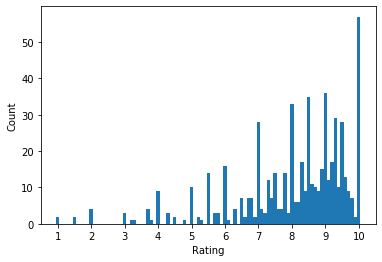

In [91]:
import matplotlib.pyplot as plt

# rating distribution
num_of_rating = [count for rating,count in rating_list]
rating = [rating for rating,count in rating_list]

plt.bar(rating, num_of_rating, width=0.1, align='center')

plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10])
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

In [92]:
## How many cocktails have a specific number of ingredients
## num_dict={num_of_ingridients: (rate<5, 5<rate<8, 8<rate<10)}

num_dict = {}
for ingr_num in receipe_df_rate['Number of Ingredients']:
    
    # number of cocktails with rating below 5
    num_of_cockt_5 = list(receipe_df_rate[receipe_df_rate['Rating']<=5]['Number of Ingredients']).count(ingr_num)
    # number of cocktails with rating between 5 and 8
    num_of_cockt_8 = list(receipe_df_rate[(receipe_df_rate['Rating']<=8) & (receipe_df_rate['Rating']>5)]['Number of Ingredients']).count(ingr_num)
    # number of cocktails with rating between 8 and 10
    num_of_cockt_10 = list(receipe_df_rate[receipe_df_rate['Rating']>8]['Number of Ingredients']).count(ingr_num)
    
    num_dict[ingr_num] = (num_of_cockt_5, num_of_cockt_8, num_of_cockt_10) 
    
num_sorted = sorted(num_dict.items(), key=lambda x: x[0])

In [93]:
# [count for ingr,count in num_sorted]

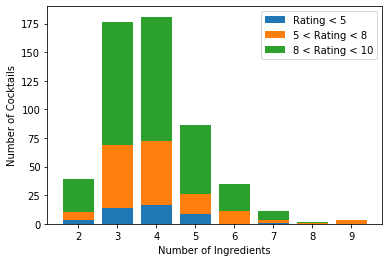

In [94]:
num_of_ingr = [ingr for ingr,count in num_sorted]

num_of_cockt_5 = [count[0] for ingr,count in num_sorted]
num_of_cockt_7 = [count[1] for ingr,count in num_sorted]
num_of_cockt_10 = [count[2] for ingr,count in num_sorted]


p1 = plt.bar(num_of_ingr, num_of_cockt_5, align='center')

p2 = plt.bar(num_of_ingr, num_of_cockt_7, bottom=num_of_cockt_5 , align='center')

p3 = plt.bar(num_of_ingr, num_of_cockt_10, bottom=num_of_cockt_7 , align='center')

plt.legend((p1,p2,p3),('Rating < 5','5 < Rating < 8 ','8 < Rating < 10'))

plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Cocktails')

plt.show()


In [61]:
receipe_df_rate["Number of Votes"].describe()

count    576.000000 
mean     21.961806  
std      135.104244 
min      1.000000   
25%      2.000000   
50%      4.000000   
75%      9.000000   
max      2673.000000
Name: Number of Votes, dtype: float64

<font color=blue> Drinks with 7,8 and 9 ingredients sorted by number of votes </font>

In [60]:

receipe_df_rate[(receipe_df_rate["Number of Ingredients"]==9)|(receipe_df_rate["Number of Ingredients"]==8)|(receipe_df_rate["Number of Ingredients"]==7)].sort_values(by="Number of Votes",ascending=False).head(10)

,Cocktail,Receipe,Rating,Number of Votes,Number of Ingredients
417,Long Island,tequila gin whiskey whiterum vodka sugarsyrup Coca-Cola® orangejuice,9.6,442.0,8
291,Fruit,orangejuice grapefruitjuice passion-fruitjuice mangojuice pineapplejuice limejuice kiwisyrup,8.6,221.0,7
416,Long Beach,tequila triplesec rum vodka gin sweetandsourmix cranberryjuice,9.3,114.0,7
0,187,RedRum®rum 99Bananas®bananaschnapps strawberrydaiquirimix sweetandsourmix triplesec powderedsugar 7-Up®soda icecream whippedcream,7.8,47.0,9
606,Sazerac,sugar ryewhiskey Deva®absinthe Peychaud®bitters Angostura®bitters lemon ice,9.5,34.0,7
292,Fruit #2,Absolut®Mandrinvodka CaptainMorgan®ParrotBaypineapplerum peachschnapps Midori®melonliqueur DeKuyper®SourApplePuckerschnapps pineapplejuice grenadinesyrup,9.3,15.0,7
317,H-Bomb,vodka tequila rum gin triplesec sweetandsourmix Hpnotiq®liqueur,9.5,15.0,7
640,Stoli Fruit,Stoli®Ohranjvodka Stoli®Razberivodka Stoli®Strasberivodka Stoli®Persikvodka orangejuice pineapplejuice grenadinesyrup 7-Up®soda icecubes,7.1,9.0,9
353,Iced Tea,darkrum brandy triplesec orangejuice limejuice cola tea,7.4,7.0,7
565,Purple,SouthernComfort®peachliqueur BlueCuracaoliqueur blueberryliqueur sloegin limejuice sweetandsourmix 7-Up®soda,5.5,4.0,7


In [17]:
# receipe_df_rate.corr(method="pearson")

# <font color='blue'> Now we look at the original data frame </font>

In [95]:
## How many cocktails have a specific number of ingredients
num_dict = {}
for ingr_num in receipe_df['Number of Ingredients']:
    num_of_cockt = list(receipe_df['Number of Ingredients']).count(ingr_num)
    num_dict[ingr_num] = num_of_cockt 
    
num_sorted = sorted(num_dict.items(), key=lambda x: x[0])
# num_sorted

In [96]:
num_of_cockt = [count for ingr,count in num_sorted]
num_of_ingr = [ingr for ingr,count in num_sorted]

# print(num_of_cockt)
# print(num_of_ingr)

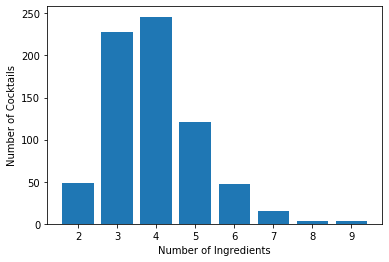

In [97]:
## plot number of cocktails vs number of ingredients

plt.bar(num_of_ingr, num_of_cockt, align='center')

plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Cocktails')

plt.show()


# <font color='blue'> Recommendation system for the original data frame </font>

In [105]:
###  Find the count matrix

count_vec = CountVectorizer() 
feature_vec = count_vec.fit_transform(receipe_df["Receipe"])


### generating the cosine similarity matrix

cos_sim = cosine_similarity(feature_vec, feature_vec)

cos_sim_df = pd.DataFrame(cos_sim )


### find the count vector 
vocab_vec = count_vec.fit(receipe_df["Receipe"])



In [106]:
# cos_sim_df

In [107]:
# vocab_vec.vocabulary_

In [108]:
# build a list of ingredients and the # of times they have been used

freq_list = sorted([(ing, count) for ing,count in vocab_vec.vocabulary_.items()], key=lambda x:x[1], reverse=True)

In [110]:
### The most used ingredients (Top 10)
freq_list_df = pd.DataFrame(freq_list, columns=['Ingredient','Number of Uses'])

freq_list_df.iloc[0:10]

,Ingredient,Number of Uses
0,zubrowka,429
1,yoghurt,428
2,yellowchartreuse,427
3,worcestershiresauce,426
4,wildturkey,425
5,whitewine,424
6,whitetequila,423
7,whitesambuca,422
8,whiterum,421
9,whiteport,420


In [112]:
# the least used ingredients

# freq_list_df.iloc[-10:]

In [113]:
## A function to show the common ingredients between two cocktails

def common_ingredients(coct1,coct2):
    index1  = receipe_df[receipe_df["Cocktail"]==coct1].index[0]
    index2  = receipe_df[receipe_df["Cocktail"]==coct2].index[0]
    
    receipe1 = receipe_df.iloc[index1]["Receipe"].split()
    receipe2 = receipe_df.iloc[index2]["Receipe"].split()
    
    common_ingr = []
    for ingredient in receipe1:
        if ingredient in receipe2:
            common_ingr.append(ingredient)
            
    return common_ingr

In [114]:
# a function to return the ingredients
def ingredients(cocktail):
    ing = receipe_df[receipe_df["Cocktail"]==cocktail]["Receipe"].values[0].split()
    return ing

In [115]:
common_ingredients("Abbey","Bijou")

['gin', 'orangebitters', 'cherry']

In [133]:
###  Build a function that gives the n best matches to two chosen cocktails ###

def cocktail_recommender2(cocktail1, cocktail2):
    coct1 = cocktail1
    coct2 = cocktail2
    ind1  = receipe_df[receipe_df["Cocktail"]==coct1].index[0]
    ind2  = receipe_df[receipe_df["Cocktail"]==coct2].index[0]

    score1 = pd.Series(cos_sim_df[ind1]).drop(labels=[ind1,ind2])    
    score2 = pd.Series(cos_sim_df[ind2]).drop(labels=[ind1,ind2])
    
    score = (score1+score2)/2
    score = score.sort_values(ascending= False)
    

    ## top 5 elements
    best_match_ind = list(score.head(5).index)



    ## add same scores as 5th cocktail in the list
    for i in range(5,712):
        if score.iloc[i+1]==score.iloc[i]:
            best_match_ind.append(list(score.iloc[i+1:i+2].index)[0])
        else:
            break
    
    
    ## make the list of at least top 5 matches     
    best_match=[]
    for i in best_match_ind:
        best_match.append(receipe_df.iloc[i][0])
        
    
        
    joint = ", "
    line = "_"*100
    print(f"If you are a fan of \"{coct1}\" and \"{coct2}\", you should also try {joint.join(best_match)}.\n{line}")
    
    coct1_ing = receipe_df.iloc[ind1]["Receipe"].split()
    coct2_ing = receipe_df.iloc[ind2]["Receipe"].split()

#     print(f"{coct1} Ingredients are: {coct1_ing}")
#     print("-"*100)
#     print(f"{coct2} Ingredients are: {coct2_ing}")

#     print("\n")
    
#     for match in best_match:
#         extra_ing = [ing for ing in ingredients(match) if ing not in ingredients(coct)]
        
#         print(f"Common Ingredients with {match}: {common_ingredients(coct,match)}, Extra Ingredients: {extra_ing}")
#         print("_"*100)
        
#         '''
    

In [134]:
cocktail_recommender2("Abbey", "Southern Gin")

If you are a fan of "Abbey" and "Southern Gin", you should also try Opal, Tailspin, Crystal Slipper, Hi Ho, Jewel, Bijou, Alaska.
____________________________________________________________________________________________________


In [126]:
###  Build a function that gives the n best matches to a chosen cocktail ###

def cocktail_recommender(cocktail_name):
    coct = cocktail_name
    ind  = receipe_df[receipe_df["Cocktail"]==coct].index[0]

    score = pd.Series(cos_sim_df[ind]).sort_values(ascending= False)

    ## ignore the score of the first index which is 1, corresponds to "coct" itself
    best_match_ind = list(score.iloc[1:6].index)



    ## add same scores as 5th cocktail in the list
    for i in range(5,712):
        if score.iloc[i+1]==score.iloc[i]:
            best_match_ind.append(list(score.iloc[i+1:i+2].index)[0])
        else:
            break
    
    
    ## make the list of at least top 5 matches     
    best_match=[]
    for i in best_match_ind:
        best_match.append(receipe_df.iloc[i][0])
        
    
        
    joint = ", "
    line = "-"*100
    print(f"If you are a fan of \"{coct}\", you should also try {joint.join(best_match)}.\n{line}")
    
    coct_ing = receipe_df.iloc[ind]["Receipe"].split()
    print(f"\"{coct}\" Ingredients are: {coct_ing}")
    print("\n")
    
    for match in best_match:
        extra_ing = [ing for ing in ingredients(match) if ing not in ingredients(coct)]
        
        print(f"Common Ingredients with \"{match}\": {common_ingredients(coct,match)}, Extra Ingredients: {extra_ing}")
        print("_"*100)
        

An example:

In [127]:
cocktail_recommender("Negroni")

If you are a fan of "Negroni", you should also try Caricature, Perfect, Fernet Branca, Farmer's, Dry Negroni.
----------------------------------------------------------------------------------------------------
"Negroni" Ingredients are: ['gin', 'sweetvermouth', 'Campari®bitters']


Common Ingredients with "Caricature": ['gin', 'sweetvermouth', 'Campari®bitters'], Extra Ingredients: ['grapefruitjuice', 'simplesyrup']
____________________________________________________________________________________________________
Common Ingredients with "Perfect": ['gin', 'sweetvermouth'], Extra Ingredients: ['dryvermouth', 'bitters']
____________________________________________________________________________________________________
Common Ingredients with "Fernet Branca": ['gin', 'sweetvermouth'], Extra Ingredients: ['FernetBranca®bitters']
____________________________________________________________________________________________________
Common Ingredients with "Farmer's": ['gin', 'sweetvermouth

In [130]:
receipe_df[(receipe_df["Cocktail"]=="Perfect")|((receipe_df["Cocktail"]=="Farmer's"))]

,Cocktail,Receipe,Rating,Number of Votes,Number of Ingredients
271,Farmer's,dryvermouth sweetvermouth gin bitters,7.0,1.0,4
538,Perfect,sweetvermouth dryvermouth gin bitters,9.2,13.0,4
